In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

In [2]:
column_names = ['algorithm', 'budget', 'distance', 'time',
                'fitness', 'route', 'prob', 'tabu_size',
                'qtd_iteracoes']


df = pd.read_table("resultados_finais.txt",
                   sep='\t',
                   names=column_names)

In [3]:
df.loc[(df['algorithm'] == 'grasp') & (df['qtd_iteracoes'].isna()), 'qtd_iteracoes'] = 100

df['qtd_iteracoes'] = df['qtd_iteracoes'].fillna(100)

In [4]:
def generate_heatmap_matrix(results_matrix, utility=True):

    if utility:
        
        columns = ['profile', 'algorithm', 'fitness-annot']

        mean_column = 'media_fitness'

    else:
        # é tempo
        columns = ['profile', 'algorithm', 'time-annot']

        mean_column = 'media_time'

    matrix_annot = results_matrix[columns].set_index('profile').pivot(columns='algorithm')

    matrix_annot = matrix_annot.sort_index(ascending=False)

    fitness_matrix = results_matrix[['profile',
                                     'algorithm',
                                     mean_column]].set_index('profile').pivot(columns='algorithm')

    fitness_matrix = fitness_matrix.sort_index(ascending=False)

    return matrix_annot, fitness_matrix

In [5]:
def evaluate_fitness(fitness):
    
    if fitness.isnumeric():
        
        return float(fitness)

    return float(fitness.replace('[', '').replace(']', ''))

In [6]:
def plot_heatmap_with_text(matrix,
                           xticks,
                           yticks,
                           annot,
                           label_text,
                           text_color,
                           y_label,
                           x_label):

    fig, ax = plt.subplots(figsize=(16, 16))
    heatmap = ax.pcolor(matrix)

    # Definindo os limites dos eixos
    ax.set_xlim(0, matrix.shape[1])
    ax.set_ylim(0, matrix.shape[0])

    # Adicionando os textos em cada célula
    for i in range(annot.shape[0]):
        for j in range(annot.shape[1]):
            
            color='white'
            
            if matrix[i, j] < text_color:
                
                color = 'black'
            
            text = ax.text(j + 0.5, i + 0.5, annot[i][j],
                           ha='center', va='center', color=color, size=25)

    # Adicionando uma barra de cores para o heatmap
    cbar = plt.colorbar(heatmap)

    cbar.set_label(label=label_text, size=25)

    cbar.ax.tick_params(labelsize=25)

    plt.ylabel(x_label, size=30)

    plt.xlabel(y_label, size=30)

    heatmap.set_cmap('YlGn')

    ax.set_xticklabels('')
    ax.set_yticklabels('')

    #print([i + 0.5 for i in range(0, len(xticks))], xticks)
    
    ax.set_xticks([i + 0.5 for i in range(0, len(xticks))],xticks, size=25, rotation=90)
    #ax.set_xticklabels(xticks, size=25, rotation=90)

    #print(yticks, [i + 0.5 for i in range(0, len(yticks))])
    
    
    ax.set_yticks([i + 0.5 for i in range(0, len(yticks))], yticks, size=25, rotation=90)
    

    # Exibindo o plot
    plt.show()

In [7]:
from scipy.stats import t

def calcular_intervalo_confianca_media(lista, confianca):

    n = len(lista)

    media = np.mean(lista)

    # Usamos ddof=1 para calcular o desvio padrão amostral
    desvio_padrao = np.std(lista, ddof=1)
    
    erro_padrao = desvio_padrao / np.sqrt(n)

    graus_lib = n - 1

    valor_critico = t.ppf((1 + confianca) / 2, df=graus_lib)

    limite_inferior = media - valor_critico * erro_padrao

    limite_superior = media + valor_critico * erro_padrao

    return media, limite_inferior, limite_superior

In [8]:
df['fitness'] = df['fitness'].apply(lambda x: evaluate_fitness(x))

In [9]:
profiles = [(500, 10000, 'A'), 
            (1000, 10000, 'C'),
            (2500, 10000, 'E'),
            (500, 20000, 'B'),
            (1000, 20000, 'D'),
            (2500, 20000, 'F')]

for profile in profiles:
    
    budget, distance, profile_name = profile

    df.loc[(df['budget'] == budget) & (df['distance'] == distance), 'profile'] = profile_name

In [10]:
complete_results = []

for algorithm in df['algorithm'].unique():
    
    for profile in df['profile'].unique():
            
        for prob in df['prob'].unique():
            
            for qtd_iter in df['qtd_iteracoes'].unique():

                for tabu_size in df['tabu_size'].unique():

                    results = {}

                    experiment_df = df[(df['algorithm'] == algorithm) &
                                       (df['profile'] == profile) &
                                       (df['prob'] == prob) &
                                       (df['tabu_size'] == tabu_size) &
                                       (df['qtd_iteracoes'] == qtd_iter)]

                    if experiment_df.empty:

                        continue

                    results['algorithm'] = algorithm
                    results['profile'] = profile
                    results['prob'] = prob
                    results['tabu_size'] = tabu_size
                    results['qtd_iteracoes'] = qtd_iter

                    mean, inf, sup = calcular_intervalo_confianca_media(experiment_df['fitness'].values, 0.95)

                    results['media_fitness'] = mean
                    results['limite_inf_fitness'] = inf
                    results['limite_sup_fitness'] = sup

                    results['fitness-annot'] = str(round(inf, 2)) + ' - ' + str(round(sup, 2))

                    mean, inf, sup = calcular_intervalo_confianca_media(experiment_df['time'].values, 0.95)

                    results['media_time'] = mean
                    results['limite_inf_time'] = inf
                    results['limite_sup_time'] = sup

                    results['time-annot'] = str(round(inf, 2)) + ' - ' + str(round(sup, 2))


                    complete_results.append(results)

In [11]:
columns_selected = ['algorithm', 'profile', 'prob', 'tabu_size', 'qtd_iteracoes',
                    'fitness-annot', 'time-annot', 'media_fitness', 'media_time']

results_matrix = pd.DataFrame(complete_results).dropna()[columns_selected]

(array([38., 39., 40., 41., 42., 43., 44., 45.]),
 [Text(0, 38.0, '38'),
  Text(0, 39.0, '39'),
  Text(0, 40.0, '40'),
  Text(0, 41.0, '41'),
  Text(0, 42.0, '42'),
  Text(0, 43.0, '43'),
  Text(0, 44.0, '44'),
  Text(0, 45.0, '45')])

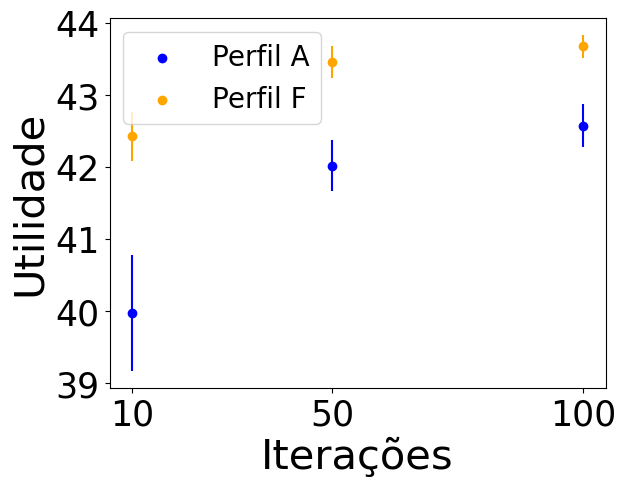

In [12]:
profile_name = {"A": "Perfil A", "F": "Perfil F"}

profile_color = {'A': 'blue', 'F': 'orange'}

columns_selected = ['algorithm', 'qtd_iteracoes', 'media_fitness', 'fitness-annot']

for profile in ['A', 'F']:

    df_grasp = results_matrix[(results_matrix['algorithm'] == 'grasp') &
                              (results_matrix['profile'] == profile)][columns_selected]


    df_grasp['min_fitness'] = df_grasp['fitness-annot'].str.split(' - ').apply(lambda x: float(x[0]))

    df_grasp['max_fitness'] = df_grasp['fitness-annot'].str.split(' - ').apply(lambda x: float(x[1]))

    plt.errorbar(df_grasp['qtd_iteracoes'], df_grasp['media_fitness'],
                 df_grasp['max_fitness'] - df_grasp['min_fitness'],
                 fmt='None', linestyle='', color=profile_color[profile])

    plt.scatter(df_grasp['qtd_iteracoes'],
                df_grasp['media_fitness'],
                label=profile_name[profile],
                color=profile_color[profile])


plt.xticks([10, 50, 100])

plt.legend(prop={'size': 20})


plt.xlabel("Iterações", fontsize=30)
plt.ylabel("Utilidade", fontsize=30)

plt.xticks(size=25)
plt.yticks(size=25)

In [13]:
y_ticks = ["GRASP", "Greedy", "BT", "Random"]

In [14]:
# Profile evaluations

profile_matrix = results_matrix[(results_matrix['prob'].isin(['0.25', 'None']) &
                                (results_matrix['tabu_size'].isin(['20', 'None'])))]

profile_matrix = profile_matrix.drop(['prob', 'tabu_size'], axis=1)

profile_matrix = profile_matrix[(results_matrix['qtd_iteracoes'] == 100)]

/tmp/ipykernel_80955/430639974.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  profile_matrix = profile_matrix[(results_matrix['qtd_iteracoes'] == 100)]


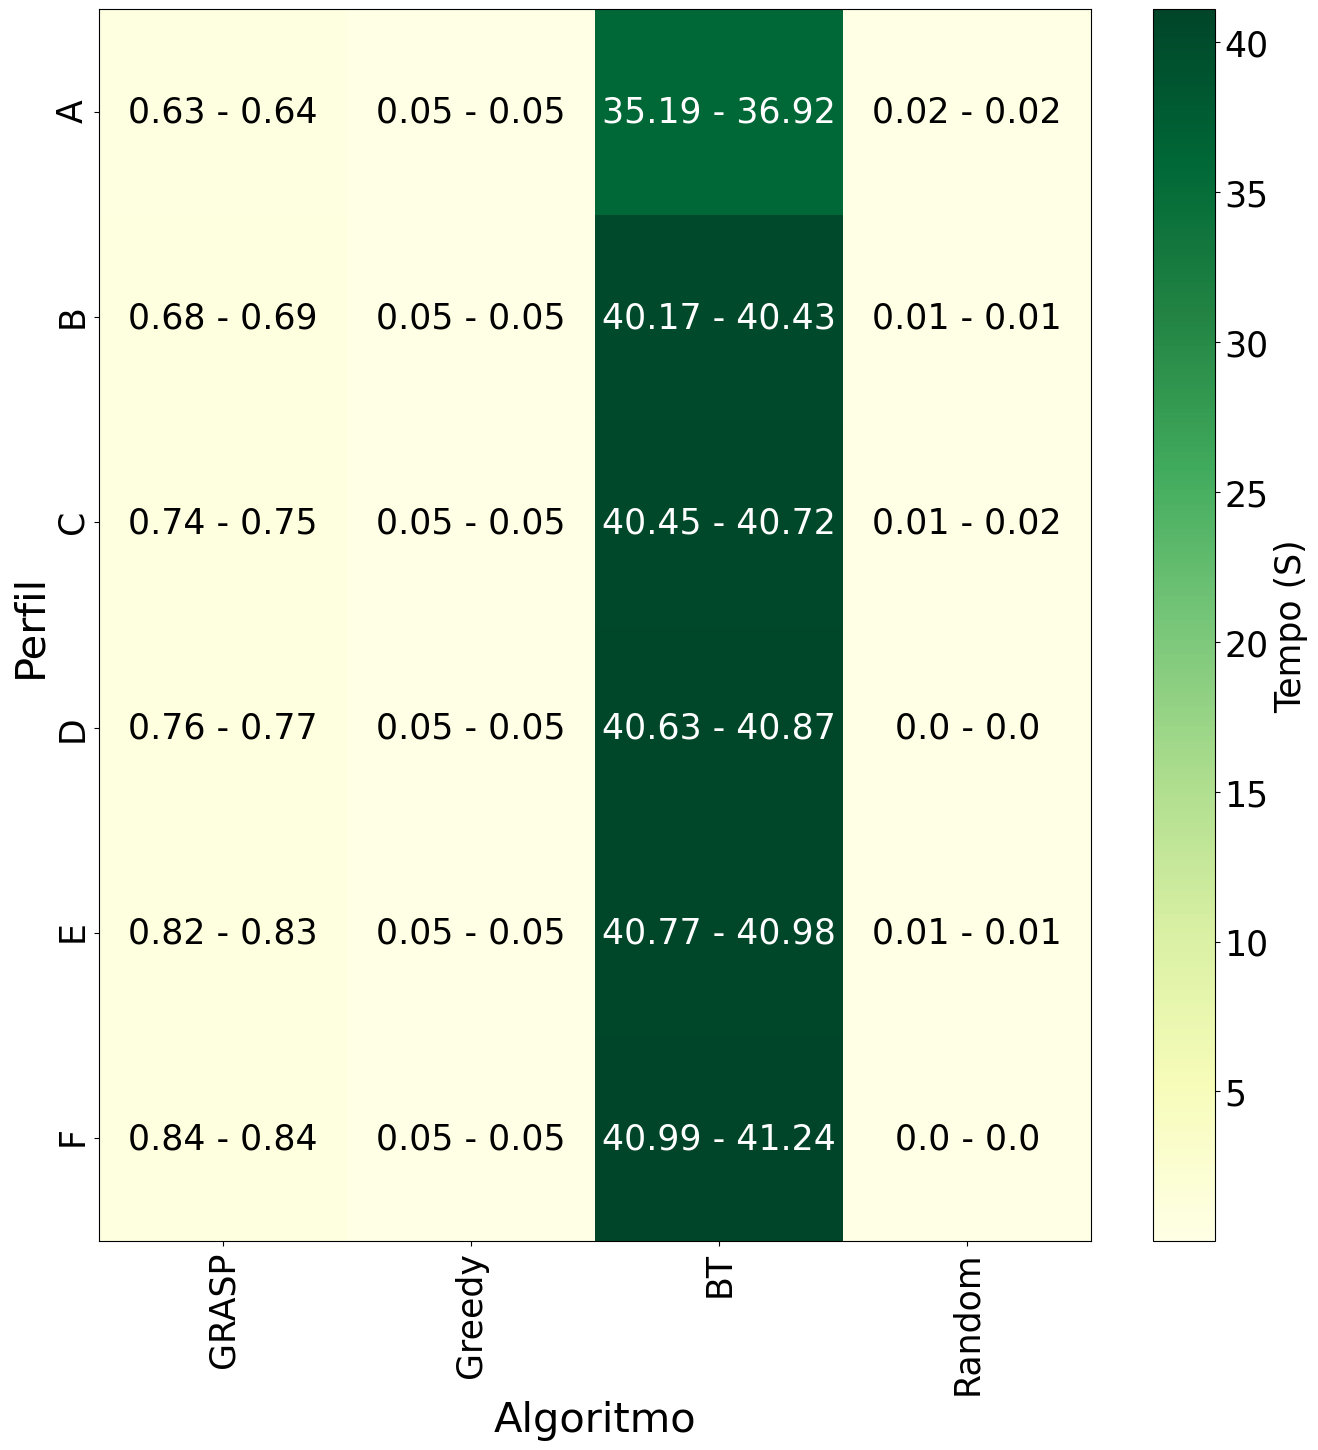

In [15]:
time_annot_matrix, time_matrix = generate_heatmap_matrix(profile_matrix, False)

plot_heatmap_with_text(time_matrix.values,
                       y_ticks,
                       time_annot_matrix.index,
                       time_annot_matrix.values,
                       "Tempo (S)",
                       20,
                       "Algoritmo",
                       "Perfil")

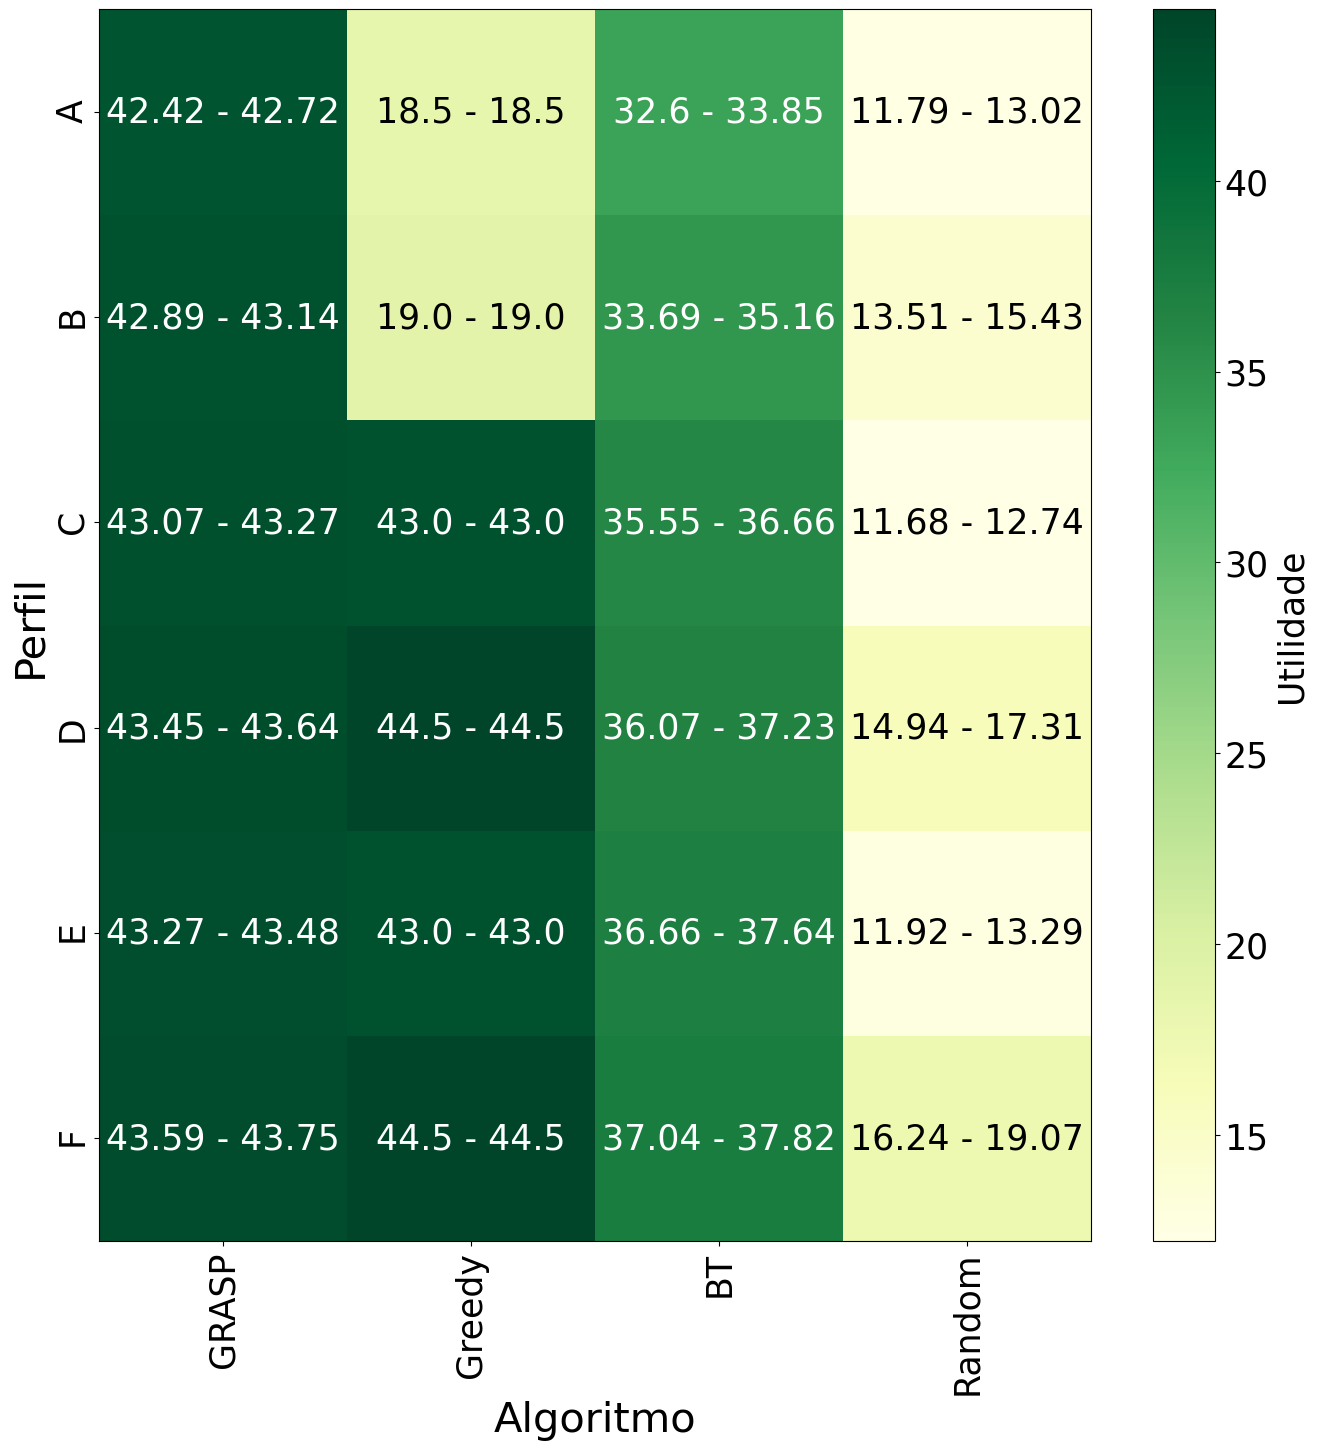

In [16]:
utility_annot_matrix, utility_matrix = generate_heatmap_matrix(profile_matrix, True)

plot_heatmap_with_text(utility_matrix.values,
                       y_ticks,
                       utility_annot_matrix.index,
                       utility_annot_matrix.values,
                       "Utilidade",
                       20,
                       "Algoritmo",
                       "Perfil")

In [17]:
def generate_its_evaluation_matrix(its_results, profile, utility):

    if utility:

        columns = ['fitness-annot', 'tabu_size', 'prob']

        main_column = 'media_fitness'

    else:

        columns = ['time-annot', 'tabu_size', 'prob']

        main_column = 'media_time'

    fitness_matrix_annot = its_results[its_results['profile'] == profile][columns].set_index('tabu_size').pivot(columns='prob')

    fitness_matrix_annot = fitness_matrix_annot.sort_index(ascending=False)

    fitness_matrix = its_results[its_results['profile'] == profile][[main_column, 'tabu_size', 'prob']].set_index('tabu_size').pivot(columns='prob')

    fitness_matrix = fitness_matrix.sort_index(ascending=False)

    return fitness_matrix_annot, fitness_matrix

In [18]:
its_results = results_matrix[results_matrix['algorithm'] == 'its']

In [19]:
#fitness_matrix_annot = its_results[its_results['profile'] == 'A'][['time-annot', 'tabu_size', 'prob']].set_index('tabu_size').pivot(columns='prob')

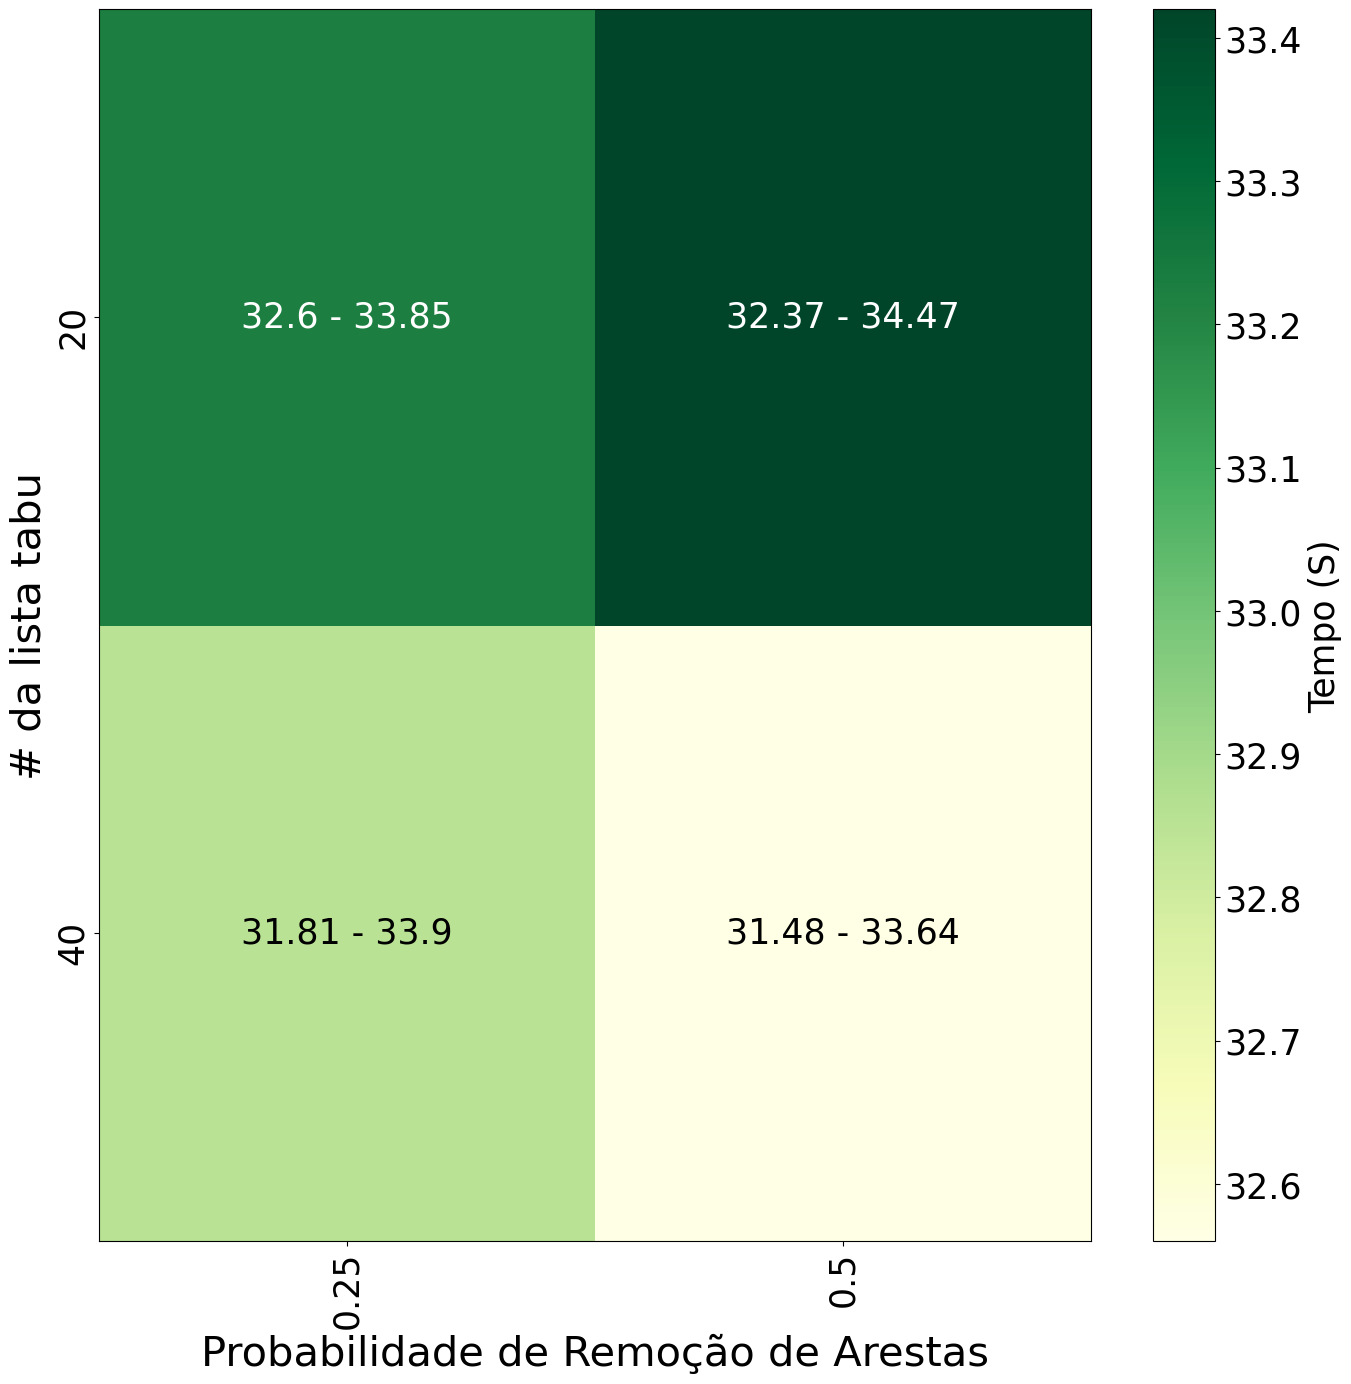

In [20]:
## Avaliações ITS

fitness_matrix_annot, fitness_matrix = generate_its_evaluation_matrix(its_results, "A", True)

plot_heatmap_with_text(fitness_matrix.values,
                       [0.25, 0.5],
                       fitness_matrix.index,
                       fitness_matrix_annot.values,
                       "Tempo (S)",
                       33,
                       "Probabilidade de Remoção de Arestas",
                       "# da lista tabu")

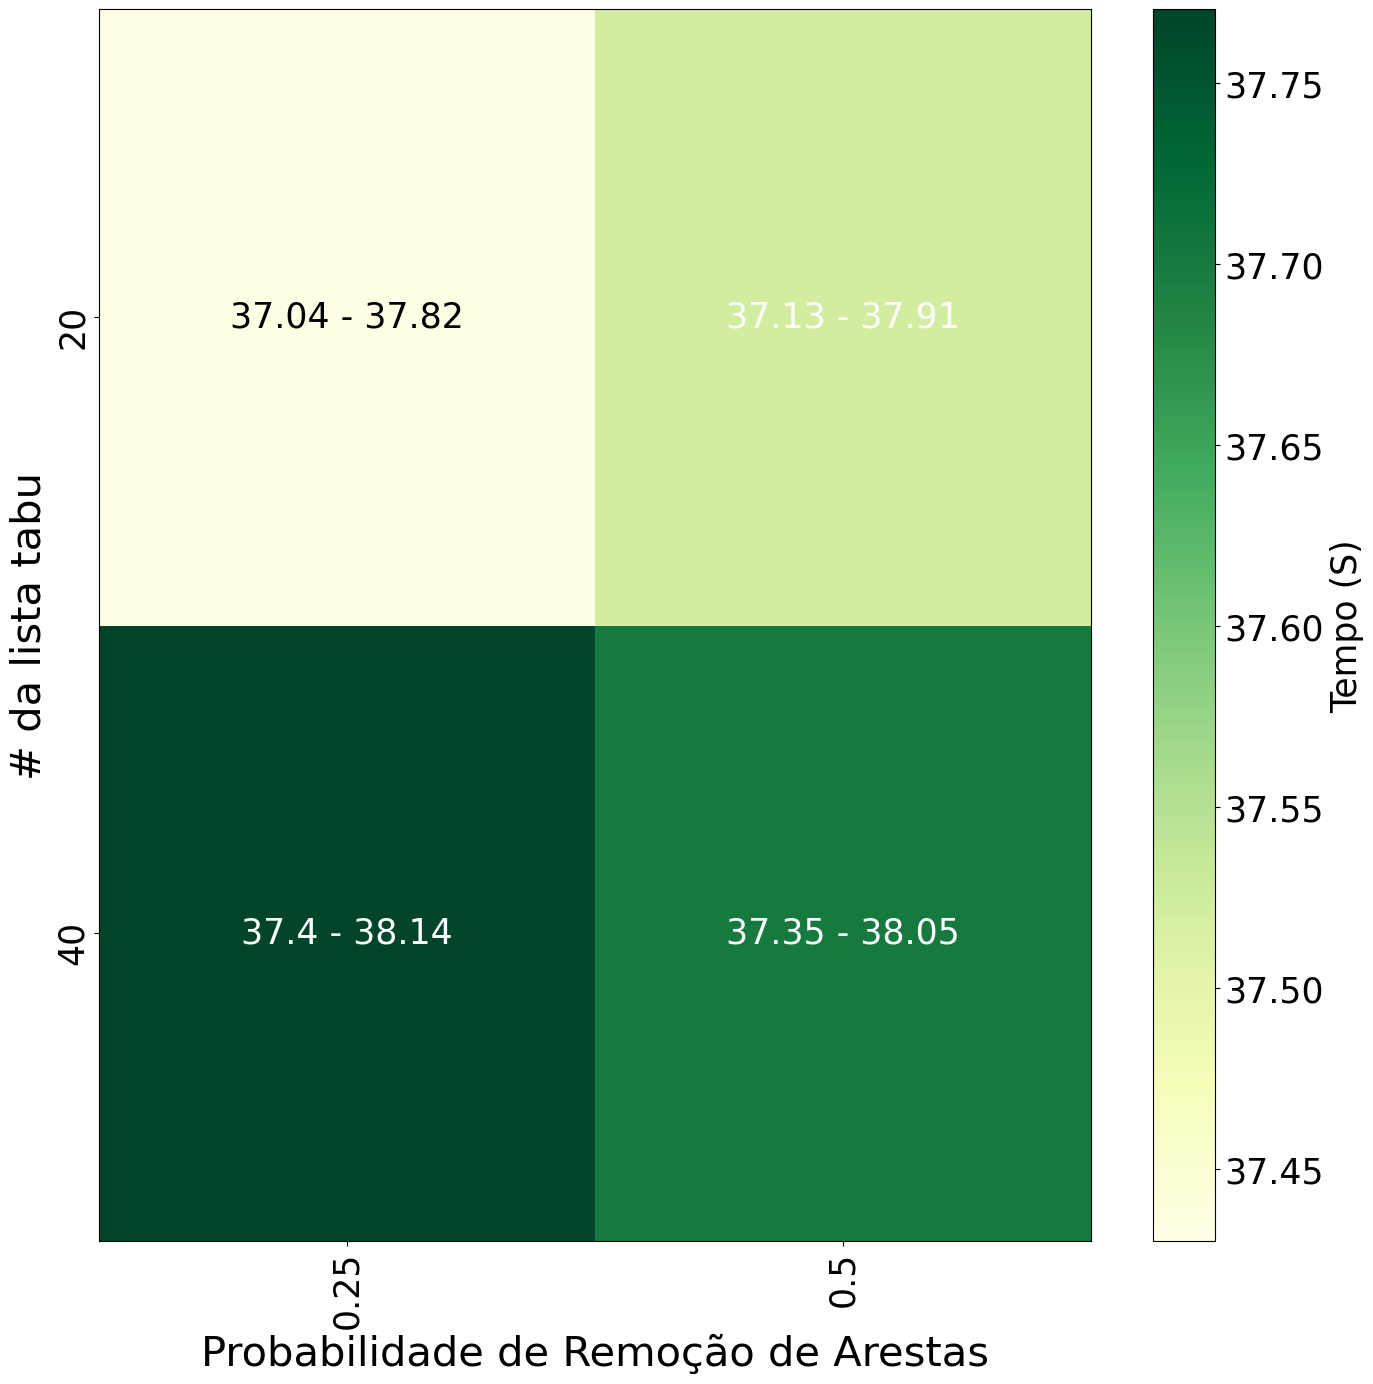

In [21]:
fitness_matrix_annot, fitness_matrix = generate_its_evaluation_matrix(its_results, "F", True)

plot_heatmap_with_text(fitness_matrix.values,
                       [0.25, 0.5],
                       fitness_matrix.index,
                       fitness_matrix_annot.values,
                       "Tempo (S)",
                       37.5,
                       "Probabilidade de Remoção de Arestas",
                       "# da lista tabu")